# Setup

In [5]:
!pip install -q statsmodels

## Import Libraries

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.linear_model import LinearRegression

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'

<ipython-input-6-5945f1de1656>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


# Data Loading

In [7]:
apple = pd.read_csv("/content/AAPL.csv")

In [8]:
apple.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-12,0.128348,0.128906,0.128348,0.128348,0.100323,469033600
1,1980-12-15,0.122210,0.122210,0.121652,0.121652,0.095089,175884800
2,1980-12-16,0.113281,0.113281,0.112723,0.112723,0.088110,105728000
3,1980-12-17,0.115513,0.116071,0.115513,0.115513,0.090291,86441600
4,1980-12-18,0.118862,0.119420,0.118862,0.118862,0.092908,73449600


In [9]:
target_columns = ['Date', 'Close']
apple = apple[target_columns]
apple.head()

,Date,Close
0,1980-12-12,0.128348
1,1980-12-15,0.121652
2,1980-12-16,0.112723
3,1980-12-17,0.115513
4,1980-12-18,0.118862


In [10]:
apple.set_index(
    pd.PeriodIndex(apple.Date, freq="D"),
    inplace=True
)
apple.drop("Date", axis=1, inplace=True)
apple.head()

,Close
Date,
1980-12-12,0.128348
1980-12-15,0.121652
1980-12-16,0.112723
1980-12-17,0.115513
1980-12-18,0.118862


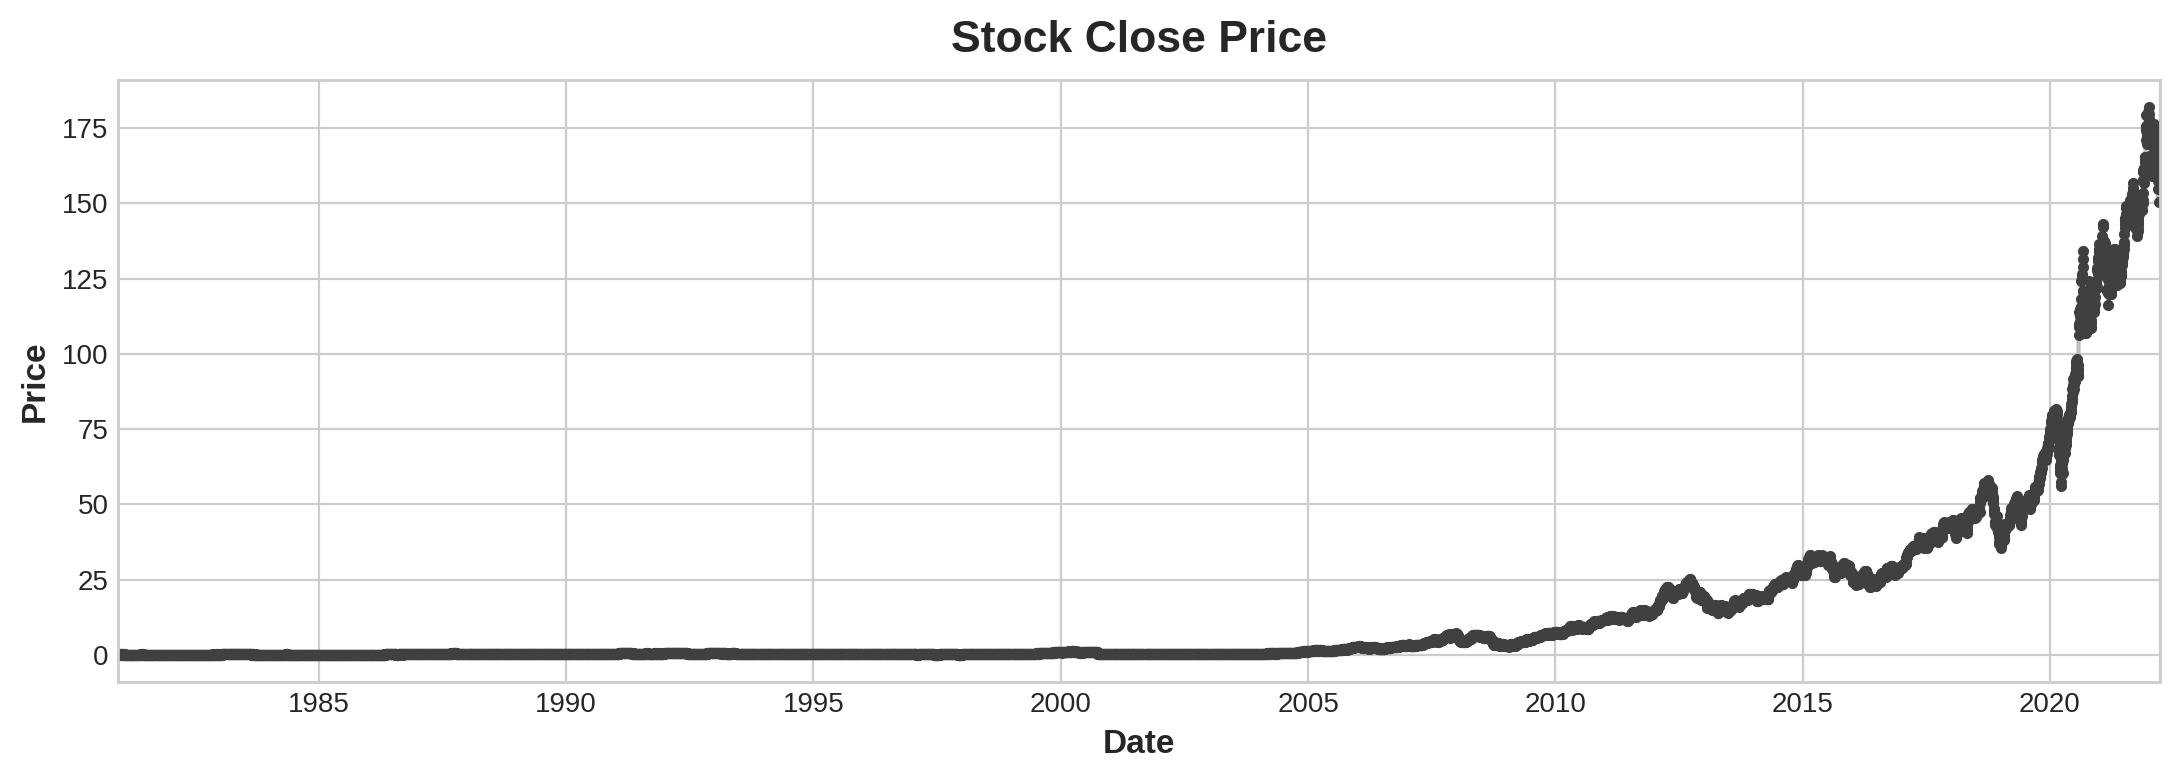

In [16]:
ax = apple.Close.plot(title="Stock Close Price", **plot_params)
_ = ax.set(ylabel="Price")

# Data Preparation

<Axes: title={'center': 'Apple Stock 365-Day Moving Average'}, xlabel='Date'>

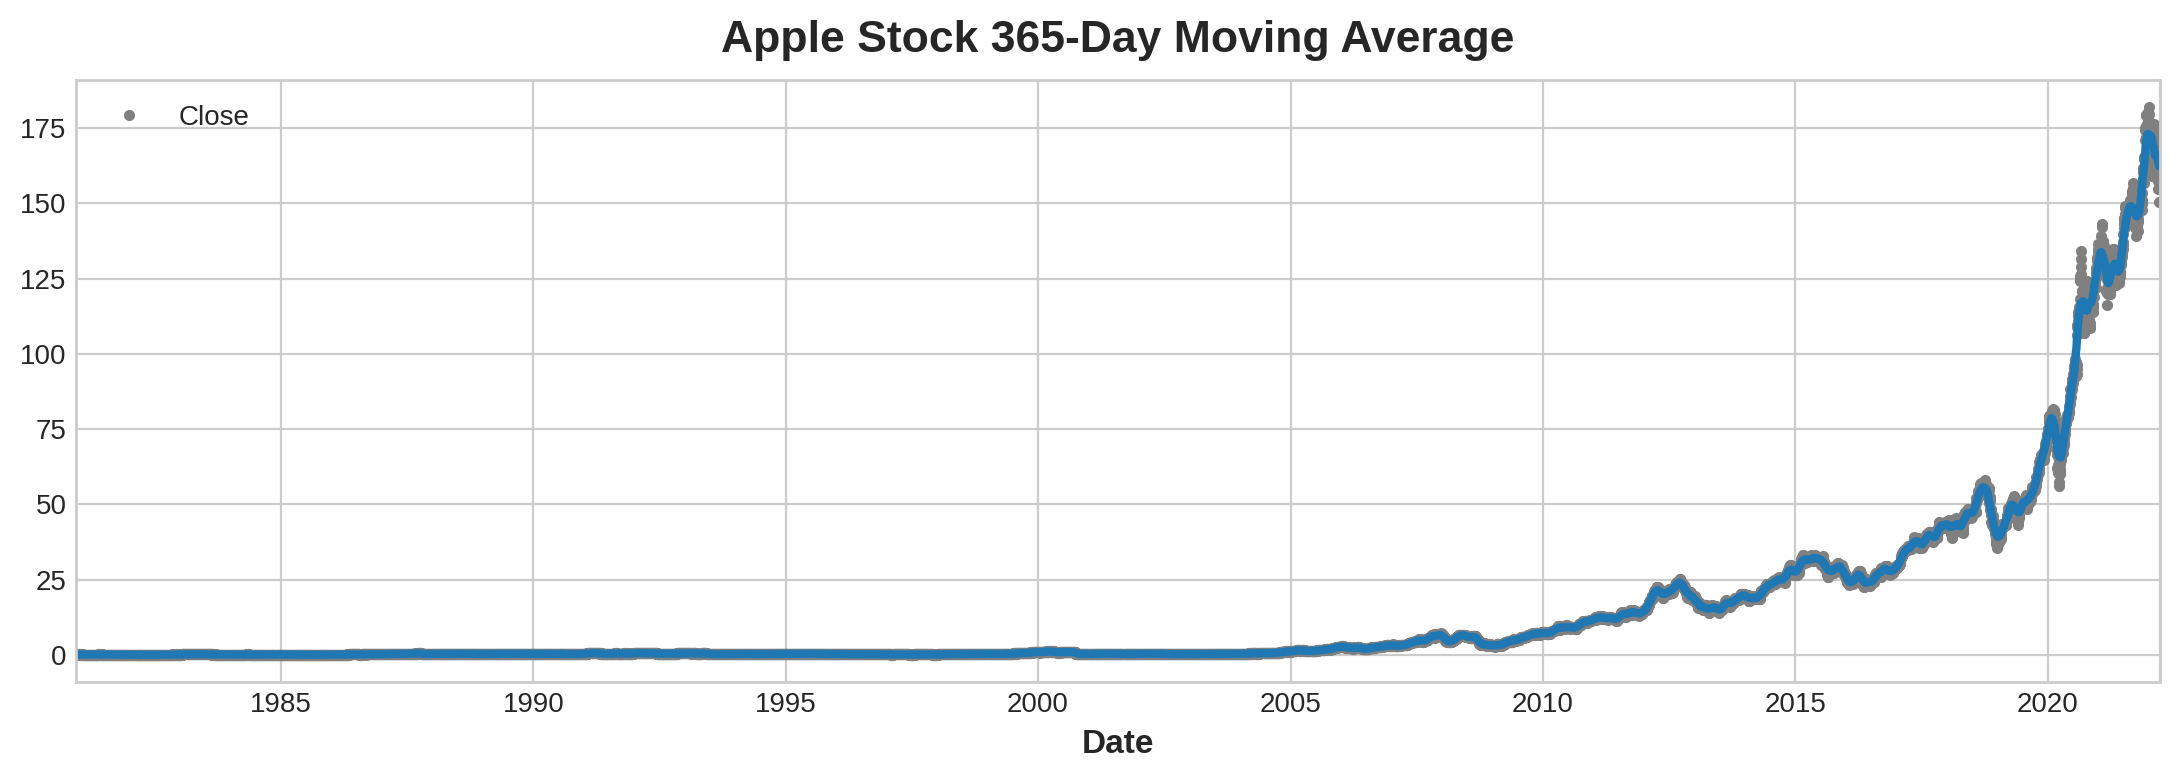

In [11]:
moving_average = apple.rolling(
    window=36,
    center=True,
    min_periods=18
).mean()

ax = apple.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Apple Stock 365-Day Moving Average", legend=False
)

# Predict Trend

In [12]:
dp = DeterministicProcess(
    index=apple.index,
    order=1,
    constant=True,
    drop=True
)

X = dp.in_sample()
X.head()

,const,trend
Date,,
1980-12-12,1.0,1.0
1980-12-15,1.0,2.0
1980-12-16,1.0,3.0
1980-12-17,1.0,4.0
1980-12-18,1.0,5.0


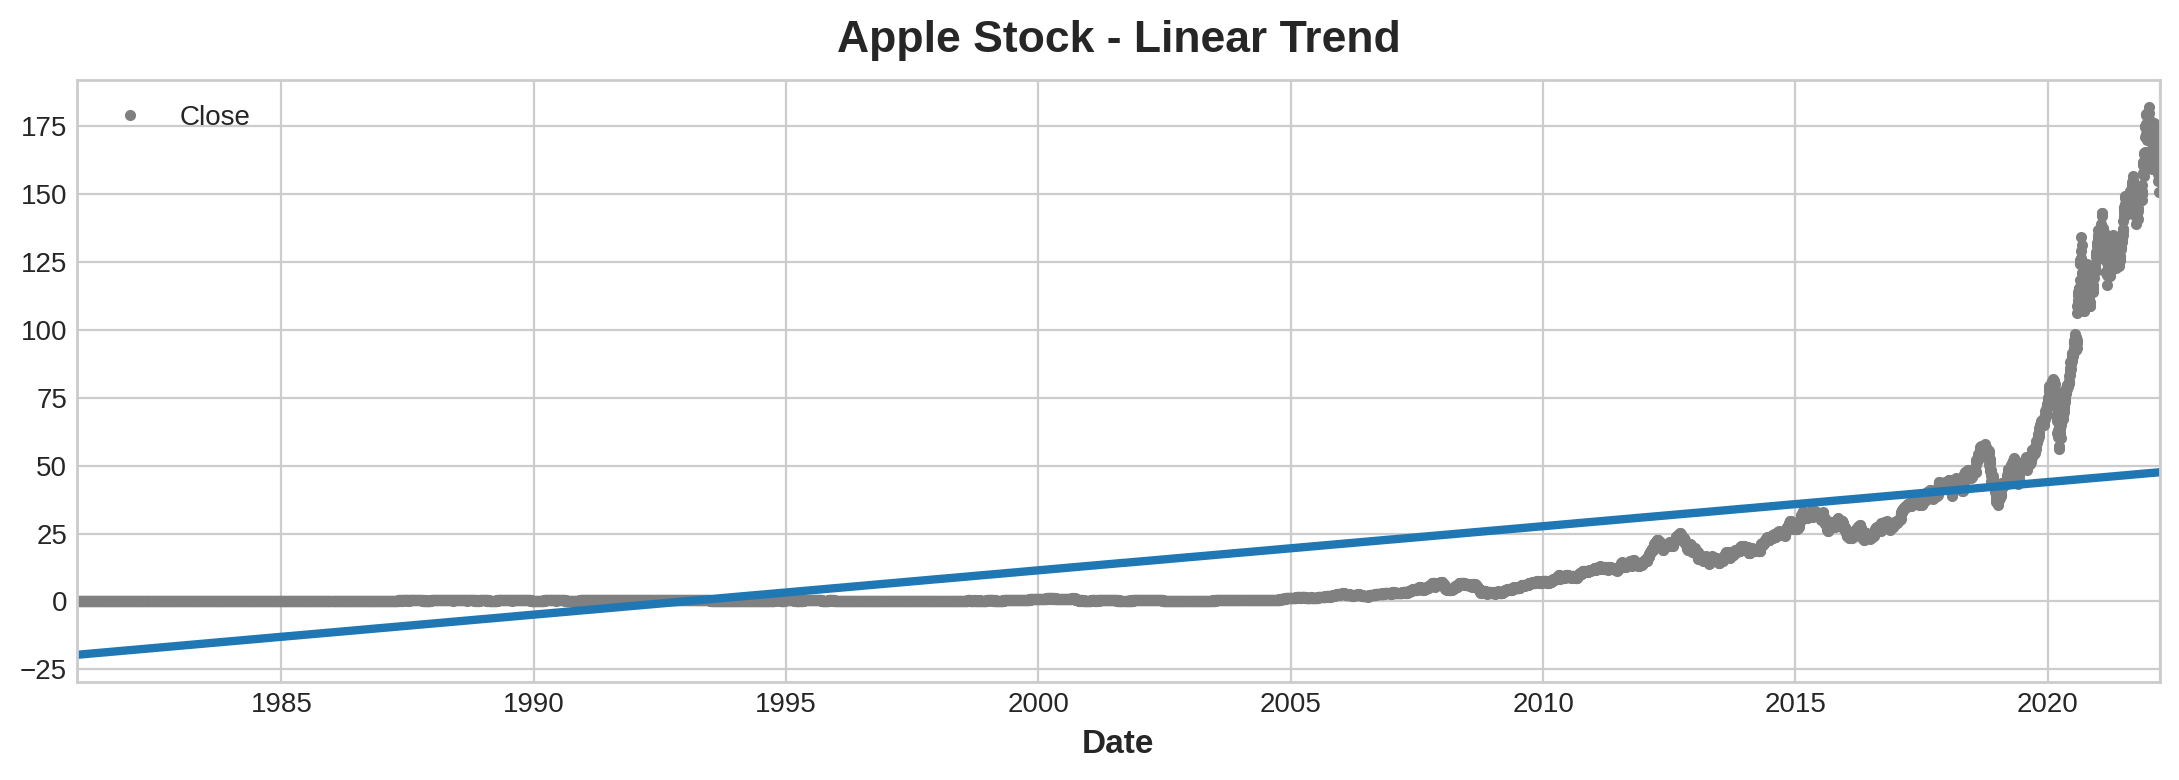

In [13]:
y = apple.Close

model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = apple.plot(style=".", color="0.5", title="Apple Stock - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [14]:
num_years = 15
X = dp.out_of_sample(steps=365 * num_years)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2022-03-25    47.588281
2022-03-26    47.594740
2022-03-27    47.601200
2022-03-28    47.607659
2022-03-29    47.614119
Freq: D, dtype: float64

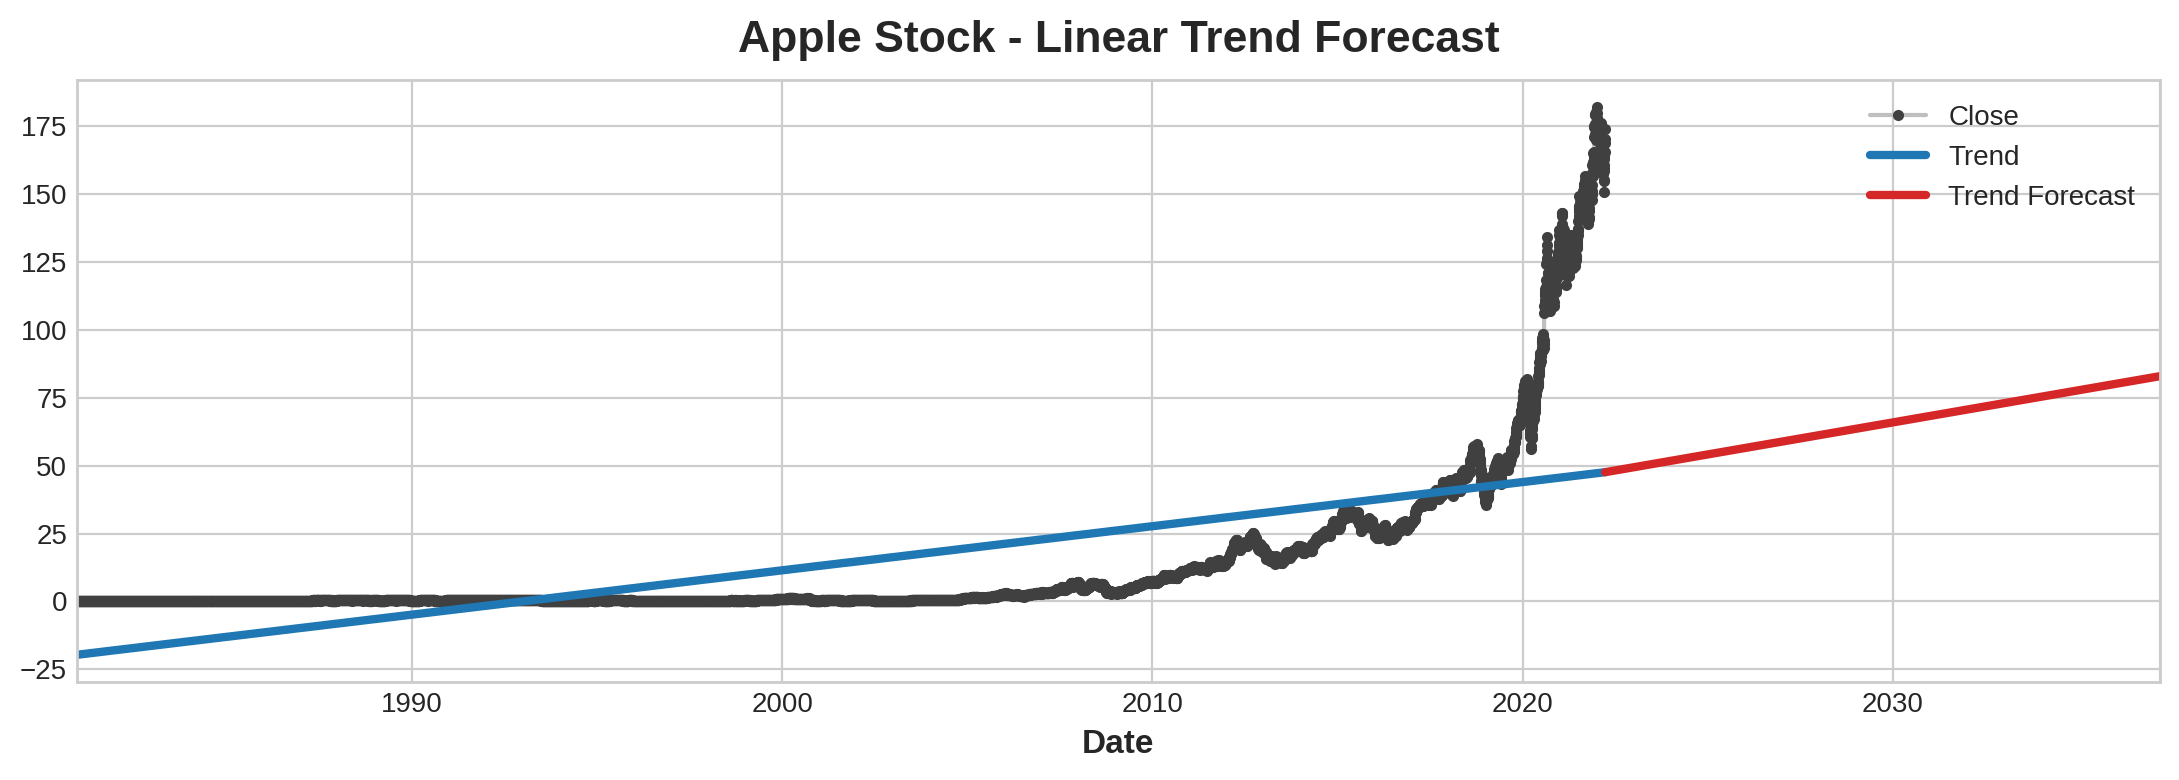

In [15]:
ax = apple.plot(title="Apple Stock - Linear Trend Forecast", **plot_params)
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3")
_ = ax.legend()

# Serial Dependencies

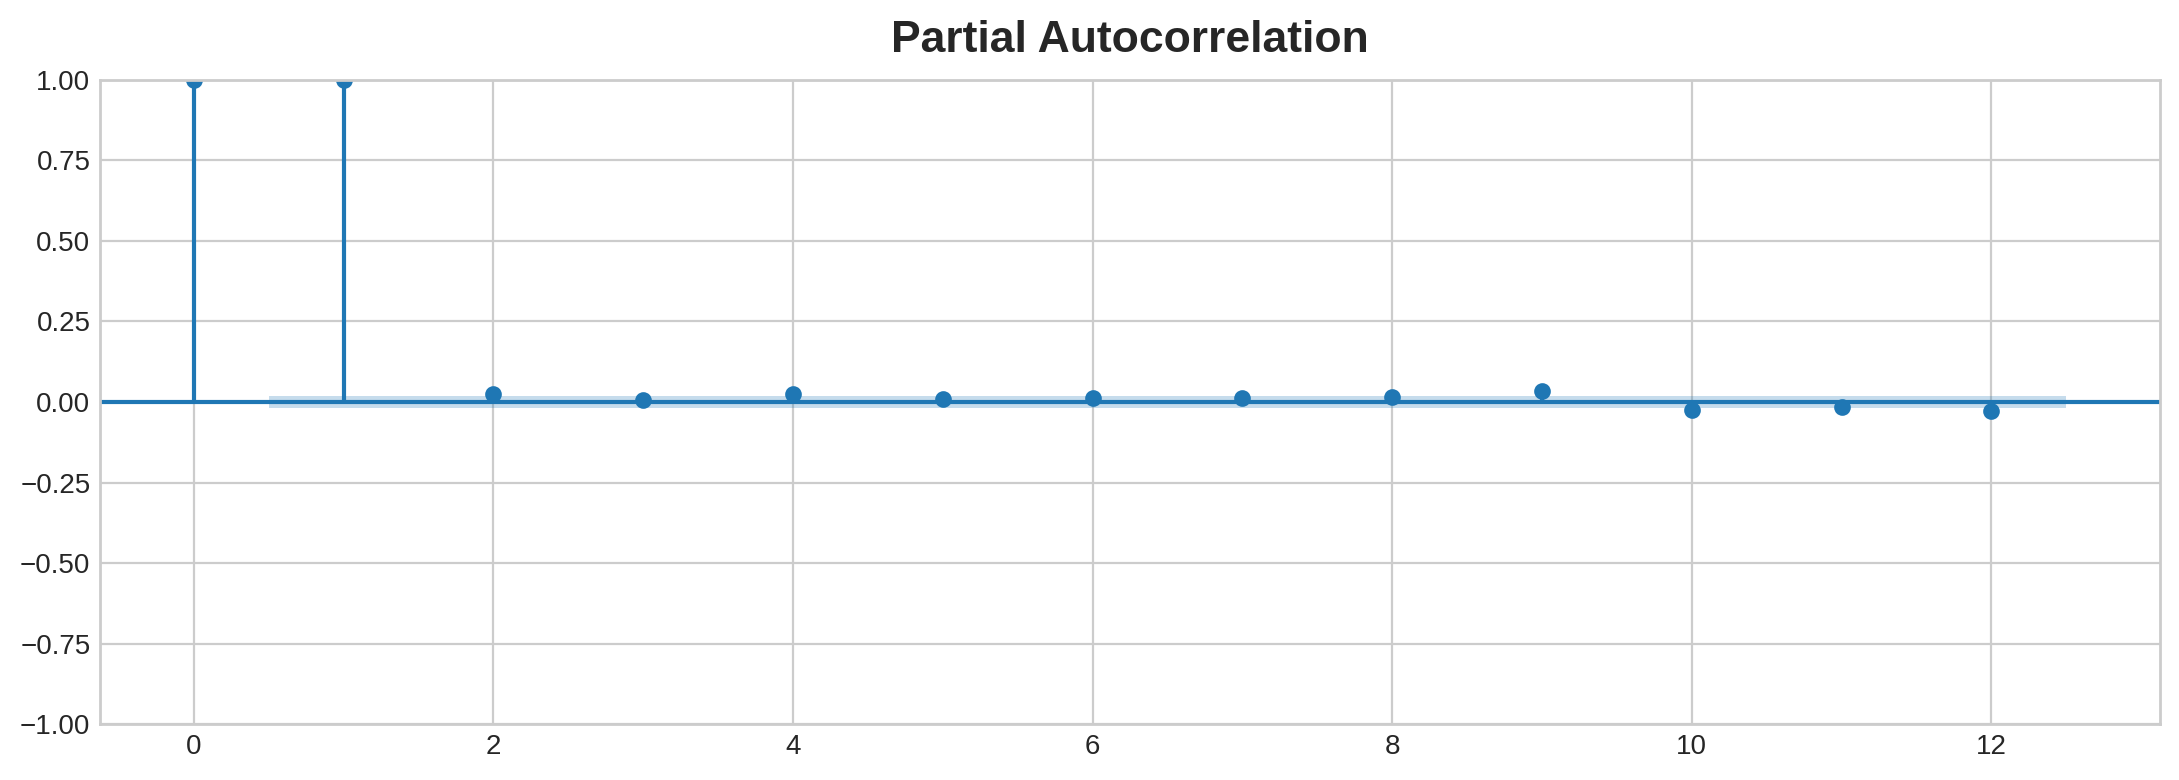

In [17]:
_ = plot_pacf(apple.Close, lags=12)

In [18]:
def make_lags(ts, lags):
  return pd.concat(
      {
          f'y_lag_{i}': ts.shift(i) for i in range(1, lags+1)
      },
      axis=1
  )

In [20]:
X = make_lags(apple.Close, lags=2)
X = X.fillna(0.0)
X.head()

,y_lag_1,y_lag_2
Date,,
1980-12-12,0.000000,0.000000
1980-12-15,0.128348,0.000000
1980-12-16,0.121652,0.128348
1980-12-17,0.112723,0.121652
1980-12-18,0.115513,0.112723


In [21]:
y = apple.Close.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = pd.Series(model.predict(X_train), index=X_train.index)
y_fore = pd.Series(model.predict(X_test), index=X_test.index)

Text(0.5, 1.0, 'Apple Stock Forecast')

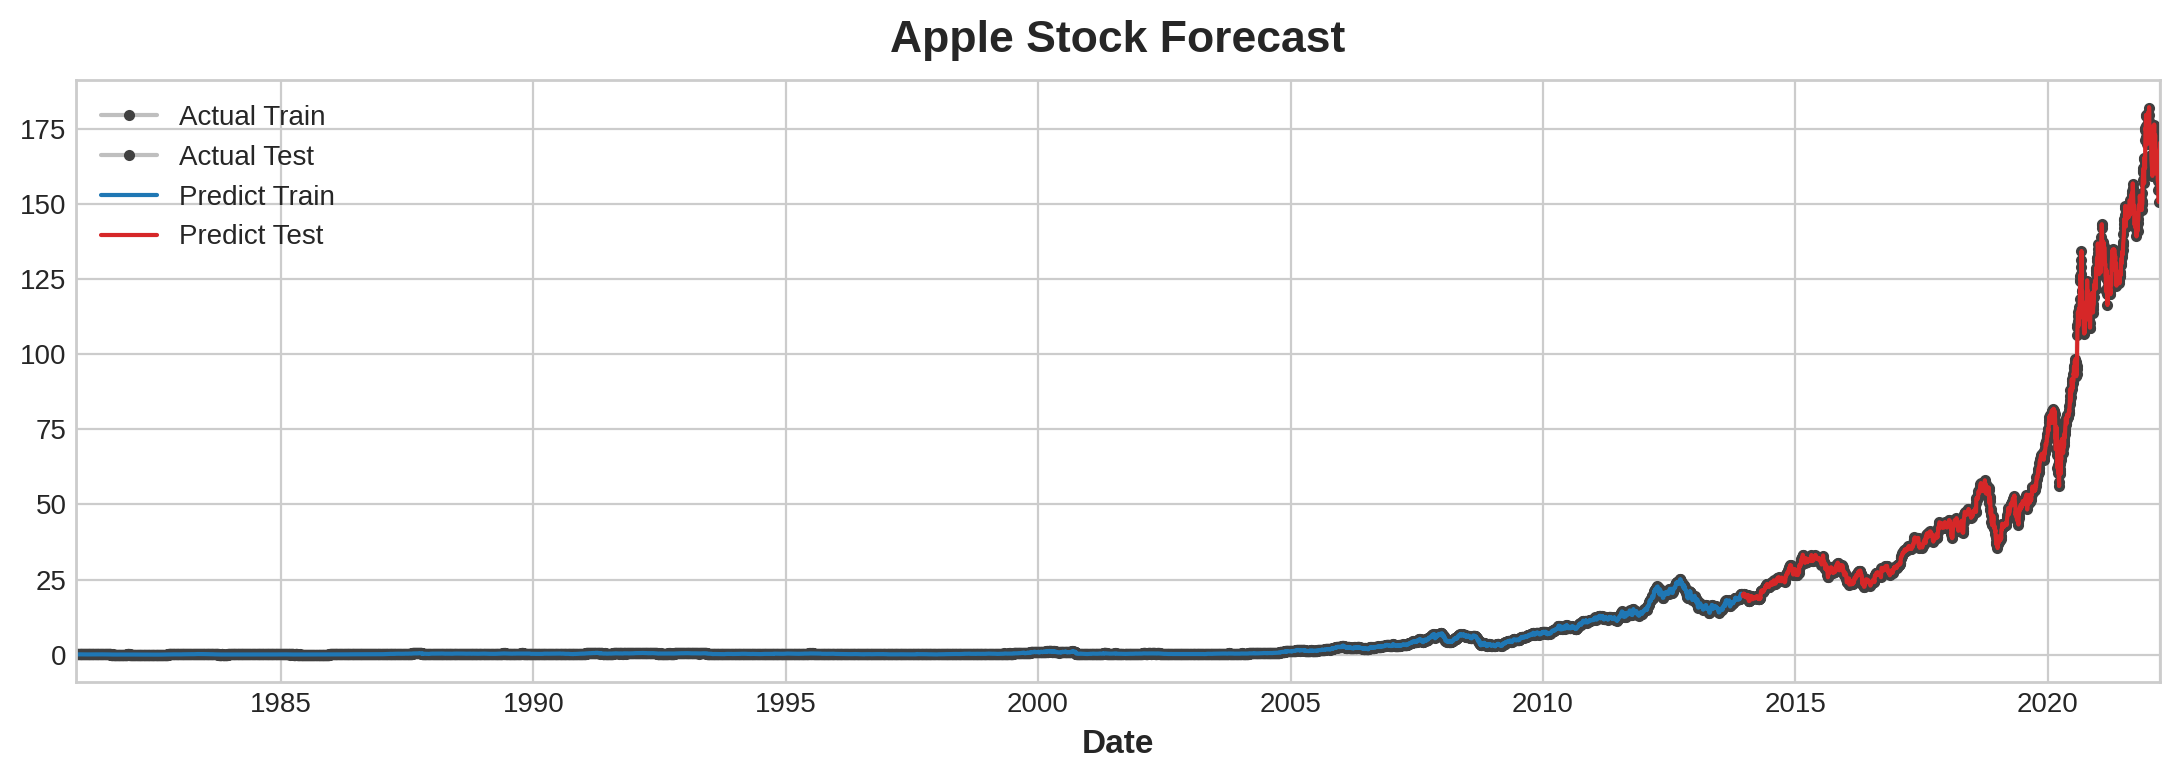

In [32]:
ax = y_train.plot(**plot_params, label="Actual Train")
ax = y_test.plot(**plot_params, label="Actual Test")
ax = y_pred.plot(ax=ax, label="Predict Train")
ax = y_fore.plot(ax=ax, color="C3", label="Predict Test")
ax.legend()
ax.set_title("Apple Stock Forecast")

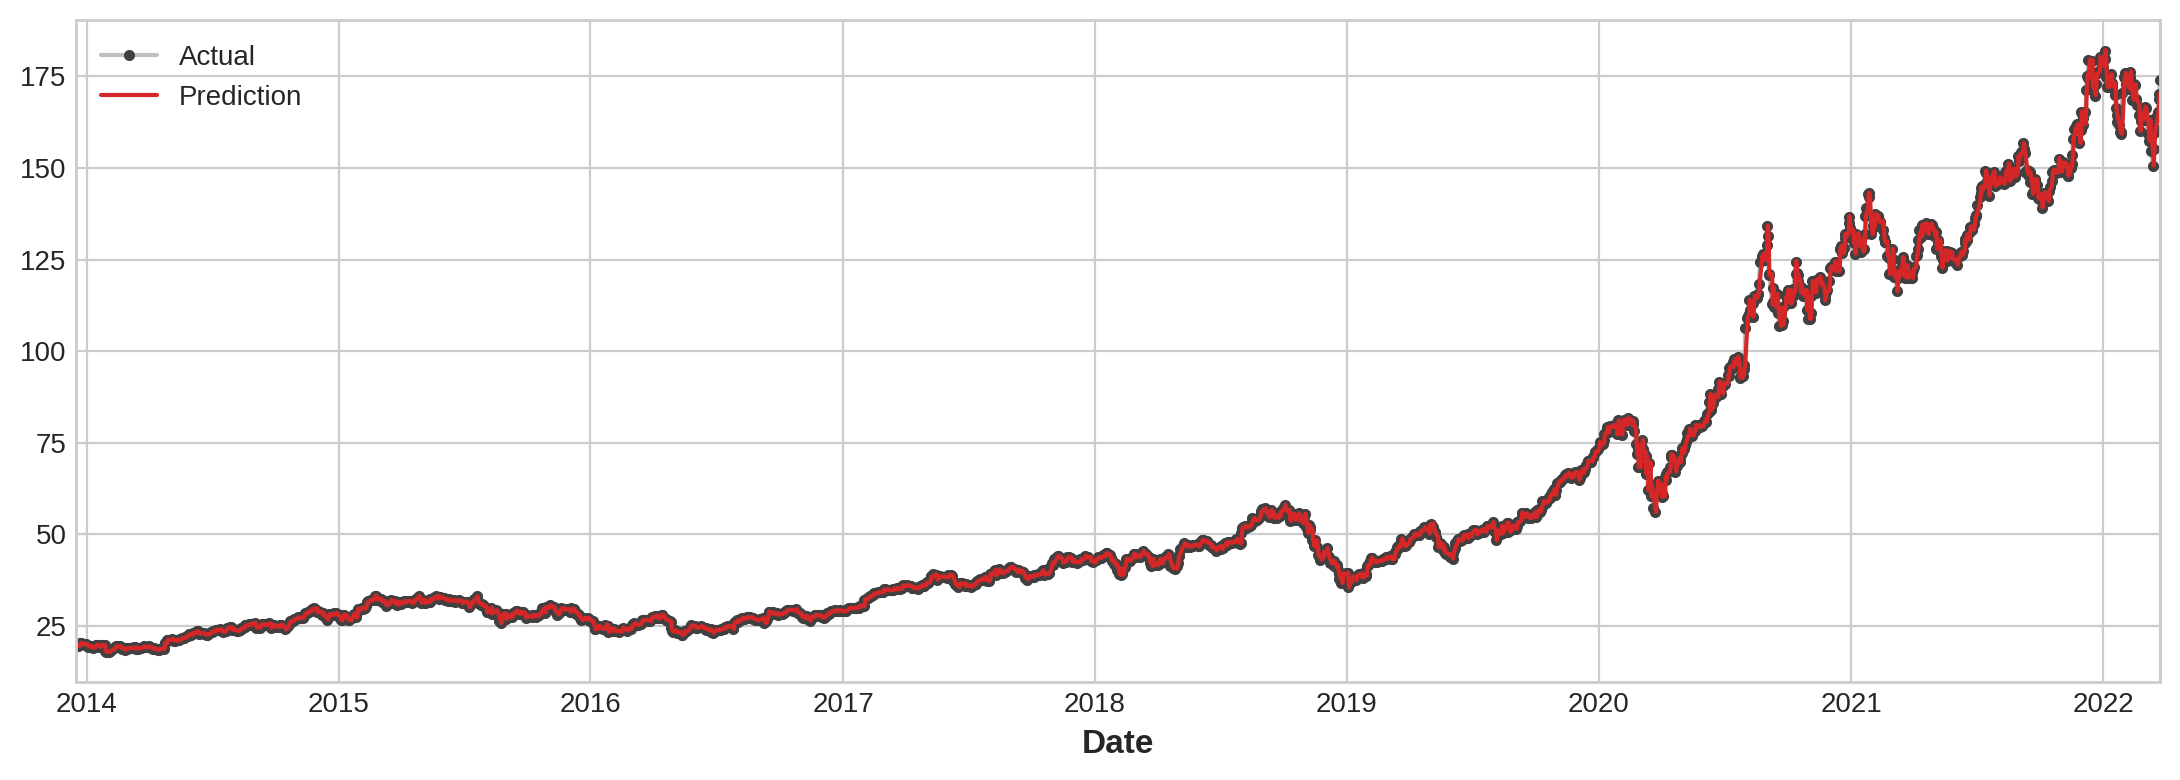

In [27]:
ax = y_test.plot(**plot_params, label="Actual", legend=True)
_ = y_fore.plot(ax=ax, color="C3", label="Prediction", legend=True)